# Train/fine-tune a model to predict tree crowns

In this notebook, we will first assess how well the pre-trained model from the [DeepForest](https://deepforest.readthedocs.io/en/latest/) package [1] performs on our dataset. We will then fine-tune the model using our annotations and compare the performance.

In [ ]:
import json
import tempfile
from os import path

import deepforest_modal_app as dma
import matplotlib.pyplot as plt
import modal
import pandas as pd
import seaborn as sns

from swiss_urban_trees import deepforest_utils, plot

/home/martibosch/miniforge3/envs/swiss-urban-trees/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# annot_df_filepath = "../data/raw/sitg-orthophoto-2019-tiles/annot.csv"
annot_dir = "../data/raw/sitg-multi-species-annot"
annot_ext = "gpkg"
# tile_dir = "../data/raw/sitg-orthophoto-2019-tiles"
tile_dir = "../data/raw/sitg-multi-species-tiles"
tile_ext = "tiff"
dst_model_filepath = "../models/fine-tuned.pl"

# model args
num_workers = 4
patch_overlap = 0.05
patch_sizes = [400, 600, 800, 1000, 1200]
iou_threshold = 0.15

# viz args
annot_color = "orange"
pred_color = "orange"
_base_plot_kwargs = {"linewidth": 2}
plot_annot_kwargs = dict({"color": annot_color}, **_base_plot_kwargs)
plot_pred_kwargs = dict({"color": pred_color}, **_base_plot_kwargs)
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

# eval args
# iou_threshold = 0.4

# train args
train_prop = 0.66
# epochs = 2
# gpus = -1  # set to -1 to use all available GPUs

# for reproducibility
random_state = 0

## Read annotations

In [ ]:
annot_gdf = deepforest_utils.get_annot_gdf(
    annot_dir=annot_dir, img_dir=tile_dir, annot_ext=annot_ext, img_ext=tile_ext
)
# show the data frame
annot_gdf.head()

GENUS                                           geometry label  \
0  Magnolia  POLYGON ((539.294 90.603, 680.582 92.931, 682....  Tree   
1  Magnolia  POLYGON ((452.299 103.551, 452.299 68.604, 418...  Tree   
2  Magnolia  POLYGON ((610.447 135.463, 611.46 73.947, 672....  Tree   
3  Platanus  POLYGON ((307.513 207.665, 307.513 104.328, 16...  Tree   
4  Magnolia  POLYGON ((437.019 188.52, 437.019 154.301, 404...  Tree   

                                     image_path        xmin        ymin  \
0  2500297.2_1116778.8_2500497.2_1116978.8.tiff  539.294008    0.000000   
1  2500297.2_1116778.8_2500497.2_1116978.8.tiff  418.501836   68.604138   
2  2500297.2_1116778.8_2500497.2_1116978.8.tiff  610.446630   73.947461   
3  2500297.2_1116778.8_2500497.2_1116978.8.tiff  163.969836  104.328138   
4  2500297.2_1116778.8_2500497.2_1116978.8.tiff  404.258836  154.301138   

         xmax        ymax  
0  682.113612   92.930791  
1  452.298836  103.551138  
2  672.546409  136.469613  
3  307.512836  207.665138  
4  437.018836  188.520138

## Compare the pre-trained and fine-tuned models

The goal of this notebook is to fine-tune the pre-trained DeepForest tree crown detection model (which has been pretrained on over 30 million algorithmically generated crowns from 22 forests and fine-tuned using 10,000 hand-labelled crowns from six forests [1]) using our annotation data.

Additionally, we will explore the effect of the "patch size" parameter, which determines the focal window size for the predictions. As [noted in the user guide](https://deepforest.readthedocs.io/en/v1.4.1/user_guide/10_better.html#check-patch-size), the prebuilt model is trained using a focal 40 m view (400x400 window at a 10 cm resolution). As a rule of thumb, the "patch size" can be increased for higher resolution images. Since our data is at the same 10 cm resolution, we could expect good results with a patch size of 400, but the best parameter may depend on further aspects of our datasets so it is better to explore different values.

In the cell below, we will start an ephemeral [Modal app](https://modal.com) on a GPU-enabled machine on the cloud using [deepforest-modal-app](https://github.com/martibosch/deepforest-modal-app) to:
1. perform inference with the pre-trained model
2. fine-tune the pre-trained model using our annotations
3. perform inference with the fine-tuned model

We will then evaluate the results locally.

In [ ]:
img_filenames = pd.Series(annot_gdf["image_path"].unique())
remote_img_dir = path.basename(tile_dir)

train_df, test_df = deepforest_utils.train_test_split(
    annot_gdf.drop(columns="geometry"),
    train_size=train_prop,
    random_state=0,
)

# run ephimeral app
with modal.enable_output():
    with dma.app.run():
        app = dma.DeepForestApp()

        # ensure images
        with tempfile.TemporaryDirectory() as tmp_dir:
            imgs_filepath = path.join(tmp_dir, "imgs.json")
            with open(imgs_filepath, "w") as dst:
                json.dump(list(img_filenames), dst)

            dma.ensure_imgs(imgs_filepath, tile_dir, remote_img_dir=remote_img_dir)

        # inference with pre-trained model
        pre_pred_gdf = pd.concat(
            [
                app.predict.remote(
                    img_filename,
                    remote_img_dir,
                    patch_size=patch_size,
                    patch_overlap=patch_overlap,
                    iou_threshold=iou_threshold,
                ).assign(**{"patch_size": patch_size})
                for img_filename in img_filenames
                for patch_size in patch_sizes
            ],
            ignore_index=True,
        )

        # fine-tune pre-trained model
        fine_tuned_filename = "crown-fine-tune.pl"
        app.retrain_crown_model.remote(
            train_df,
            remote_img_dir,
            test_df=test_df,
            dst_filename=fine_tuned_filename,
        )

        # inference with fine-tuned model
        ft_pred_gdf = pd.concat(
            [
                app.predict.remote(
                    img_filename,
                    remote_img_dir,
                    checkpoint_filename=fine_tuned_filename,
                    patch_size=patch_size,
                    patch_overlap=patch_overlap,
                    iou_threshold=iou_threshold,
                ).assign(**{"patch_size": patch_size})
                for img_filename in img_filenames
                for patch_size in patch_sizes
            ],
            ignore_index=True,
        )

Output()

✓ Initialized. View run at https://modal.com/apps/martibosch/main/ap-CqytwSNdlOECxVNDHR21BT

Output()

Building image im-emdvHIPdkzE0iQLqQAYfrr



=> Step 0: FROM base



=> Step 1: ENV HF_HUB_CACHE=/models/hf_hub_cache



=> Step 2: ENV TORCH_HOME=/models/torch


Saving image...


Image saved, took 2.65s



Built image im-emdvHIPdkzE0iQLqQAYfrr in 4.08s




✓ Created objects.
├── 🔨 Created mount PythonPackage:deepforest_modal_app
└── 🔨 Created function DeepForestApp.*.

Output()

/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


/models/torch
/models/torch/hub
Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /models/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]


  8%|▊         | 10.6M/130M [00:00<00:01, 110MB/s]


 16%|█▋        | 21.2M/130M [00:00<00:01, 107MB/s]


 24%|██▍       | 31.5M/130M [00:00<00:01, 104MB/s]


 32%|███▏      | 41.5M/130M [00:00<00:00, 101MB/s]


 40%|███▉      | 51.5M/130M [00:00<00:00, 102MB/s]


 47%|████▋     | 61.8M/130M [00:00<00:00, 103MB/s]


 56%|█████▌    | 72.5M/130M [00:00<00:00, 106MB/s]


 64%|██████▍   | 83.6M/130M [00:00<00:00, 109MB/s]


 72%|███████▏  | 94.1M/130M [00:00<00:00, 109MB/s]


 81%|████████  | 105M/130M [00:01<00:00, 112MB/s] 


 90%|█████████ | 118M/130M [00:01<00:00, 117MB/s]100%|██████████| 130M/130M [00:01<00:00, 111MB/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 400, overlap 0.05, and IOU threshold 0.15.


You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/36 [00:01<00:44,  0.80it/s]


Predicting DataLoader 0:   6%|▌         | 2/36 [00:01<00:22,  1.53it/s]


Predicting DataLoader 0:   8%|▊         | 3/36 [00:01<00:14,  2.26it/s]


Predicting DataLoader 0:  11%|█         | 4/36 [00:01<00:10,  2.98it/s]


Predicting DataLoader 0:  14%|█▍        | 5/36 [00:01<00:08,  3.68it/s]


Predicting DataLoader 0:  17%|█▋        | 6/36 [00:01<00:06,  4.36it/s]


Predicting DataLoader 0:  19%|█▉        | 7/36 [00:01<00:05,  5.04it/s]


Predicting DataLoader 0:  22%|██▏       | 8/36 [00:01<00:04,  5.69it/s]


Predicting DataLoader 0:  25%|██▌       | 9/36 [00:01<00:04,  6.34it/s]


Predicting DataLoader 0:  28%|██▊       | 10/36 [00:01<00:03,  6.97it/s]


Predicting DataLoader 0:  31%|███       | 11/36 [00:01<00:03,  7.59it/s]


Predicting DataLoader 0:  33%|███▎      | 12/36 [00:01<00:02,  8.20it/s]


Predicting DataLoader 0:  36%|███▌      | 13/36 [00:01<00:02,  8.79it/s]


Predicting DataLoader 0:  39%|███▉      | 14/36 [00:01<00:02,  9.38it/s]


Predicting DataLoader 0:  42%|████▏     | 15/36 [00:01<00:02,  9.93it/s]


Predicting DataLoader 0:  44%|████▍     | 16/36 [00:01<00:01, 10.49it/s]


Predicting DataLoader 0:  47%|████▋     | 17/36 [00:01<00:01, 11.03it/s]


Predicting DataLoader 0:  50%|█████     | 18/36 [00:01<00:01, 11.57it/s]


Predicting DataLoader 0:  53%|█████▎    | 19/36 [00:01<00:01, 12.09it/s]


Predicting DataLoader 0:  56%|█████▌    | 20/36 [00:01<00:01, 12.60it/s]


Predicting DataLoader 0:  58%|█████▊    | 21/36 [00:01<00:01, 13.11it/s]


Predicting DataLoader 0:  61%|██████    | 22/36 [00:01<00:01, 13.61it/s]


Predicting DataLoader 0:  64%|██████▍   | 23/36 [00:01<00:00, 14.09it/s]


Predicting DataLoader 0:  67%|██████▋   | 24/36 [00:01<00:00, 14.57it/s]


Predicting DataLoader 0:  69%|██████▉   | 25/36 [00:01<00:00, 15.03it/s]


Predicting DataLoader 0:  72%|███████▏  | 26/36 [00:01<00:00, 15.48it/s]


Predicting DataLoader 0:  75%|███████▌  | 27/36 [00:01<00:00, 15.92it/s]


Predicting DataLoader 0:  78%|███████▊  | 28/36 [00:01<00:00, 16.36it/s]


Predicting DataLoader 0:  81%|████████  | 29/36 [00:01<00:00, 16.80it/s]


Predicting DataLoader 0:  83%|████████▎ | 30/36 [00:01<00:00, 17.20it/s]


Predicting DataLoader 0:  86%|████████▌ | 31/36 [00:01<00:00, 17.62it/s]


Predicting DataLoader 0:  89%|████████▉ | 32/36 [00:01<00:00, 18.03it/s]


Predicting DataLoader 0:  92%|█████████▏| 33/36 [00:01<00:00, 18.43it/s]


Predicting DataLoader 0:  94%|█████████▍| 34/36 [00:01<00:00, 18.84it/s]


Predicting DataLoader 0:  97%|█████████▋| 35/36 [00:01<00:00, 19.23it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:01<00:00, 19.61it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:01<00:00, 19.60it/s]


371 predictions in overlapping windows, applying non-max supression
257 predictions kept after non-max suppression


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 600, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▋         | 1/16 [00:00<00:01, 10.46it/s]


Predicting DataLoader 0:  12%|█▎        | 2/16 [00:00<00:00, 17.39it/s]


Predicting DataLoader 0:  19%|█▉        | 3/16 [00:00<00:00, 22.11it/s]


Predicting DataLoader 0:  25%|██▌       | 4/16 [00:00<00:00, 25.96it/s]


Predicting DataLoader 0:  31%|███▏      | 5/16 [00:00<00:00, 29.41it/s]


Predicting DataLoader 0:  38%|███▊      | 6/16 [00:00<00:00, 32.42it/s]


Predicting DataLoader 0:  44%|████▍     | 7/16 [00:00<00:00, 34.93it/s]


Predicting DataLoader 0:  50%|█████     | 8/16 [00:00<00:00, 36.80it/s]


Predicting DataLoader 0:  56%|█████▋    | 9/16 [00:00<00:00, 38.46it/s]


Predicting DataLoader 0:  62%|██████▎   | 10/16 [00:00<00:00, 40.03it/s]


Predicting DataLoader 0:  69%|██████▉   | 11/16 [00:00<00:00, 41.40it/s]


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 42.62it/s]


Predicting DataLoader 0:  81%|████████▏ | 13/16 [00:00<00:00, 43.75it/s]


Predicting DataLoader 0:  88%|████████▊ | 14/16 [00:00<00:00, 44.71it/s]


Predicting DataLoader 0:  94%|█████████▍| 15/16 [00:00<00:00, 45.63it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 46.34it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 46.30it/s]


136 predictions in overlapping windows, applying non-max supression
97 predictions kept after non-max suppression


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 800, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00,  9.08it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 15.07it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 19.08it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 22.52it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 25.17it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 27.52it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 29.30it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 30.74it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 32.27it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 32.23it/s]


60 predictions in overlapping windows, applying non-max supression
45 predictions kept after non-max suppression


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 1000, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00,  8.05it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 13.46it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 17.44it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 20.47it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 22.90it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 25.09it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 26.76it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 28.00it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 29.38it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 29.35it/s]


82 predictions in overlapping windows, applying non-max supression
36 predictions kept after non-max suppression


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 1200, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00,  8.52it/s]


Predicting DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 13.39it/s]


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 16.91it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 19.56it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 19.52it/s]


31 predictions in overlapping windows, applying non-max supression
25 predictions kept after non-max suppression


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 400, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/36 [00:00<00:05,  6.61it/s]


Predicting DataLoader 0:   6%|▌         | 2/36 [00:00<00:02, 11.68it/s]


Predicting DataLoader 0:   8%|▊         | 3/36 [00:00<00:02, 15.75it/s]


Predicting DataLoader 0:  11%|█         | 4/36 [00:00<00:01, 19.22it/s]


Predicting DataLoader 0:  14%|█▍        | 5/36 [00:00<00:01, 22.45it/s]


Predicting DataLoader 0:  17%|█▋        | 6/36 [00:00<00:01, 25.22it/s]


Predicting DataLoader 0:  19%|█▉        | 7/36 [00:00<00:01, 27.77it/s]


Predicting DataLoader 0:  22%|██▏       | 8/36 [00:00<00:00, 29.94it/s]


Predicting DataLoader 0:  25%|██▌       | 9/36 [00:00<00:00, 31.85it/s]

Predicting DataLoader 0:  28%|██▊       | 10/36 [00:00<00:00, 33.57it/s]


Predicting DataLoader 0:  31%|███       | 11/36 [00:00<00:00, 35.19it/s]


Predicting DataLoader 0:  33%|███▎      | 12/36 [00:00<00:00, 36.58it/s]


Predicting DataLoader 0:  36%|███▌      | 13/36 [00:00<00:00, 37.92it/s]


Predicting DataLoader 0:  39%|███▉      | 14/36 [00:00<00:00, 38.94it/s]


Predicting DataLoader 0:  42%|████▏     | 15/36 [00:00<00:00, 40.03it/s]


Predicting DataLoader 0:  44%|████▍     | 16/36 [00:00<00:00, 41.03it/s]


Predicting DataLoader 0:  47%|████▋     | 17/36 [00:00<00:00, 42.02it/s]


Predicting DataLoader 0:  50%|█████     | 18/36 [00:00<00:00, 42.94it/s]


Predicting DataLoader 0:  53%|█████▎    | 19/36 [00:00<00:00, 43.81it/s]


Predicting DataLoader 0:  56%|█████▌    | 20/36 [00:00<00:00, 44.43it/s]


Predicting DataLoader 0:  58%|█████▊    | 21/36 [00:00<00:00, 45.11it/s]


Predicting DataLoader 0:  61%|██████    | 22/36 [00:00<00:00, 45.77it/s]


Predicting DataLoader 0:  64%|██████▍   | 23/36 [00:00<00:00, 46.44it/s]


Predicting DataLoader 0:  67%|██████▋   | 24/36 [00:00<00:00, 47.08it/s]


Predicting DataLoader 0:  69%|██████▉   | 25/36 [00:00<00:00, 47.56it/s]


Predicting DataLoader 0:  72%|███████▏  | 26/36 [00:00<00:00, 47.96it/s]


Predicting DataLoader 0:  75%|███████▌  | 27/36 [00:00<00:00, 48.44it/s]


Predicting DataLoader 0:  78%|███████▊  | 28/36 [00:00<00:00, 48.92it/s]


Predicting DataLoader 0:  81%|████████  | 29/36 [00:00<00:00, 49.44it/s]


Predicting DataLoader 0:  83%|████████▎ | 30/36 [00:00<00:00, 49.76it/s]


Predicting DataLoader 0:  86%|████████▌ | 31/36 [00:00<00:00, 50.03it/s]


Predicting DataLoader 0:  89%|████████▉ | 32/36 [00:00<00:00, 50.33it/s]


Predicting DataLoader 0:  92%|█████████▏| 33/36 [00:00<00:00, 50.66it/s]


Predicting DataLoader 0:  94%|█████████▍| 34/36 [00:00<00:00, 51.02it/s]


Predicting DataLoader 0:  97%|█████████▋| 35/36 [00:00<00:00, 51.44it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 51.73it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 51.71it/s]


638 predictions in overlapping windows, applying non-max supression
467 predictions kept after non-max suppression


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 600, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▋         | 1/16 [00:00<00:01,  9.10it/s]


Predicting DataLoader 0:  12%|█▎        | 2/16 [00:00<00:00, 15.40it/s]


Predicting DataLoader 0:  19%|█▉        | 3/16 [00:00<00:00, 19.75it/s]


Predicting DataLoader 0:  25%|██▌       | 4/16 [00:00<00:00, 23.17it/s]


Predicting DataLoader 0:  31%|███▏      | 5/16 [00:00<00:00, 26.32it/s]


Predicting DataLoader 0:  38%|███▊      | 6/16 [00:00<00:00, 29.02it/s]


Predicting DataLoader 0:  44%|████▍     | 7/16 [00:00<00:00, 31.28it/s]


Predicting DataLoader 0:  50%|█████     | 8/16 [00:00<00:00, 33.03it/s]


Predicting DataLoader 0:  56%|█████▋    | 9/16 [00:00<00:00, 34.71it/s]


Predicting DataLoader 0:  62%|██████▎   | 10/16 [00:00<00:00, 36.15it/s]


Predicting DataLoader 0:  69%|██████▉   | 11/16 [00:00<00:00, 37.27it/s]


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 38.37it/s]


Predicting DataLoader 0:  81%|████████▏ | 13/16 [00:00<00:00, 39.08it/s]


Predicting DataLoader 0:  88%|████████▊ | 14/16 [00:00<00:00, 40.01it/s]


Predicting DataLoader 0:  94%|█████████▍| 15/16 [00:00<00:00, 40.77it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 41.55it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 41.52it/s]


271 predictions in overlapping windows, applying non-max supression
184 predictions kept after non-max suppression


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 800, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00,  8.61it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 14.39it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 18.40it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 21.68it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 24.31it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 26.74it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 28.28it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 29.71it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 31.19it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 31.15it/s]


146 predictions in overlapping windows, applying non-max supression
100 predictions kept after non-max suppression


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 1000, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:01,  6.64it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 11.31it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 14.75it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 17.42it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 19.85it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 21.97it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 23.72it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 25.05it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 26.34it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 26.31it/s]


175 predictions in overlapping windows, applying non-max supression
80 predictions kept after non-max suppression


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 1200, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00,  6.29it/s]


Predicting DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 10.58it/s]


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 13.85it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 16.43it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 16.40it/s]


62 predictions in overlapping windows, applying non-max supression
52 predictions kept after non-max suppression


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 400, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/36 [00:00<00:04,  7.87it/s]


Predicting DataLoader 0:   6%|▌         | 2/36 [00:00<00:02, 13.94it/s]


Predicting DataLoader 0:   8%|▊         | 3/36 [00:00<00:01, 18.39it/s]


Predicting DataLoader 0:  11%|█         | 4/36 [00:00<00:01, 22.26it/s]


Predicting DataLoader 0:  14%|█▍        | 5/36 [00:00<00:01, 25.69it/s]


Predicting DataLoader 0:  17%|█▋        | 6/36 [00:00<00:01, 28.75it/s]


Predicting DataLoader 0:  19%|█▉        | 7/36 [00:00<00:00, 31.20it/s]


Predicting DataLoader 0:  22%|██▏       | 8/36 [00:00<00:00, 33.29it/s]


Predicting DataLoader 0:  25%|██▌       | 9/36 [00:00<00:00, 35.10it/s]


Predicting DataLoader 0:  28%|██▊       | 10/36 [00:00<00:00, 36.82it/s]


Predicting DataLoader 0:  31%|███       | 11/36 [00:00<00:00, 38.33it/s]


Predicting DataLoader 0:  33%|███▎      | 12/36 [00:00<00:00, 39.65it/s]


Predicting DataLoader 0:  36%|███▌      | 13/36 [00:00<00:00, 40.87it/s]


Predicting DataLoader 0:  39%|███▉      | 14/36 [00:00<00:00, 41.95it/s]


Predicting DataLoader 0:  42%|████▏     | 15/36 [00:00<00:00, 42.90it/s]


Predicting DataLoader 0:  44%|████▍     | 16/36 [00:00<00:00, 43.89it/s]


Predicting DataLoader 0:  47%|████▋     | 17/36 [00:00<00:00, 44.90it/s]


Predicting DataLoader 0:  50%|█████     | 18/36 [00:00<00:00, 45.85it/s]


Predicting DataLoader 0:  53%|█████▎    | 19/36 [00:00<00:00, 46.53it/s]


Predicting DataLoader 0:  56%|█████▌    | 20/36 [00:00<00:00, 47.20it/s]


Predicting DataLoader 0:  58%|█████▊    | 21/36 [00:00<00:00, 47.84it/s]


Predicting DataLoader 0:  61%|██████    | 22/36 [00:00<00:00, 48.49it/s]


Predicting DataLoader 0:  64%|██████▍   | 23/36 [00:00<00:00, 49.00it/s]


Predicting DataLoader 0:  67%|██████▋   | 24/36 [00:00<00:00, 49.52it/s]


Predicting DataLoader 0:  69%|██████▉   | 25/36 [00:00<00:00, 49.93it/s]


Predicting DataLoader 0:  72%|███████▏  | 26/36 [00:00<00:00, 50.42it/s]


Predicting DataLoader 0:  75%|███████▌  | 27/36 [00:00<00:00, 50.88it/s]


Predicting DataLoader 0:  78%|███████▊  | 28/36 [00:00<00:00, 51.33it/s]


Predicting DataLoader 0:  81%|████████  | 29/36 [00:00<00:00, 51.78it/s]


Predicting DataLoader 0:  83%|████████▎ | 30/36 [00:00<00:00, 52.22it/s]


Predicting DataLoader 0:  86%|████████▌ | 31/36 [00:00<00:00, 52.51it/s]


Predicting DataLoader 0:  89%|████████▉ | 32/36 [00:00<00:00, 52.80it/s]


Predicting DataLoader 0:  92%|█████████▏| 33/36 [00:00<00:00, 53.11it/s]


Predicting DataLoader 0:  94%|█████████▍| 34/36 [00:00<00:00, 53.38it/s]


Predicting DataLoader 0:  97%|█████████▋| 35/36 [00:00<00:00, 53.65it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 53.97it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 53.95it/s]


235 predictions in overlapping windows, applying non-max supression
167 predictions kept after non-max suppression


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 600, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▋         | 1/16 [00:00<00:01, 10.29it/s]


Predicting DataLoader 0:  12%|█▎        | 2/16 [00:00<00:00, 17.04it/s]


Predicting DataLoader 0:  19%|█▉        | 3/16 [00:00<00:00, 21.45it/s]


Predicting DataLoader 0:  25%|██▌       | 4/16 [00:00<00:00, 25.42it/s]


Predicting DataLoader 0:  31%|███▏      | 5/16 [00:00<00:00, 28.79it/s]


Predicting DataLoader 0:  38%|███▊      | 6/16 [00:00<00:00, 31.58it/s]


Predicting DataLoader 0:  44%|████▍     | 7/16 [00:00<00:00, 33.82it/s]


Predicting DataLoader 0:  50%|█████     | 8/16 [00:00<00:00, 35.81it/s]


Predicting DataLoader 0:  56%|█████▋    | 9/16 [00:00<00:00, 37.45it/s]


Predicting DataLoader 0:  62%|██████▎   | 10/16 [00:00<00:00, 38.91it/s]


Predicting DataLoader 0:  69%|██████▉   | 11/16 [00:00<00:00, 40.26it/s]


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 41.31it/s]


Predicting DataLoader 0:  81%|████████▏ | 13/16 [00:00<00:00, 42.30it/s]


Predicting DataLoader 0:  88%|████████▊ | 14/16 [00:00<00:00, 43.29it/s]


Predicting DataLoader 0:  94%|█████████▍| 15/16 [00:00<00:00, 43.98it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.80it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 44.76it/s]


132 predictions in overlapping windows, applying non-max supression
94 predictions kept after non-max suppression


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 800, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00,  9.61it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 16.06it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 20.48it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 23.79it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 26.48it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 28.94it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 30.62it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 32.22it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 33.75it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 33.71it/s]


62 predictions in overlapping windows, applying non-max supression
45 predictions kept after non-max suppression


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 1000, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:01,  6.46it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 11.03it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 14.36it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 17.11it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 19.44it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 21.42it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 23.03it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 24.24it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 25.56it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 25.52it/s]


65 predictions in overlapping windows, applying non-max supression
31 predictions kept after non-max suppression


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 1200, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00,  7.55it/s]


Predicting DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 12.45it/s]


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 15.83it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 18.40it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 18.37it/s]


14 predictions in overlapping windows, applying non-max supression
12 predictions kept after non-max suppression


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name                 | Type                  | Params | Mode 
-----------------------------------------------------------------------
0 | model                | RetinaNet             | 32.1 M | eval 
1 | iou_metric           | IntersectionOverUnion | 0      | train
2 | mAP_metric           | MeanAveragePrecision  | 0      | train
3 | empty_frame_accuracy | BinaryAccuracy        | 0      | train
-----------------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
3         Modules in train mode
202       Modules in eval mode
UserWarning: Got processor for bboxes, but no transform to process it.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]


UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s]


UserWarning: Converting predictions to GeoDataFrame using geometry column


FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]                                    


Training: |          | 0/? [00:00<?, ?it/s]Training:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] Epoch 0: 100%|██████████| 1/1 [00:01<00:00,  0.87it/s]


Epoch 0: 100%|██████████| 1/1 [00:01<00:00,  0.87it/s, v_num=1]



Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0%|          | 0/2 [00:00<?, ?it/s]



Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]



Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s]



UserWarning: Converting predictions to GeoDataFrame using geometry column


FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  8.08it/s]
                                                                      


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.41it/s, v_num=1]Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.41it/s, v_num=1]Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  0.41it/s, v_num=1]


`Trainer.fit` stopped: `max_epochs=1` reached.


--- Model retrained in 4.54 seconds ---


Saved checkpoint to /models/deepforest/crown-fine-tune.pl


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 400, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/36 [00:00<00:00, 60.67it/s]


Predicting DataLoader 0:   6%|▌         | 2/36 [00:00<00:00, 66.33it/s]


Predicting DataLoader 0:   8%|▊         | 3/36 [00:00<00:00, 68.61it/s]


Predicting DataLoader 0:  11%|█         | 4/36 [00:00<00:00, 70.25it/s]


Predicting DataLoader 0:  14%|█▍        | 5/36 [00:00<00:00, 71.10it/s]


Predicting DataLoader 0:  17%|█▋        | 6/36 [00:00<00:00, 71.90it/s]


Predicting DataLoader 0:  19%|█▉        | 7/36 [00:00<00:00, 72.35it/s]


Predicting DataLoader 0:  22%|██▏       | 8/36 [00:00<00:00, 72.72it/s]


Predicting DataLoader 0:  25%|██▌       | 9/36 [00:00<00:00, 72.97it/s]


Predicting DataLoader 0:  28%|██▊       | 10/36 [00:00<00:00, 73.22it/s]


Predicting DataLoader 0:  31%|███       | 11/36 [00:00<00:00, 73.53it/s]


Predicting DataLoader 0:  33%|███▎      | 12/36 [00:00<00:00, 73.81it/s]


Predicting DataLoader 0:  36%|███▌      | 13/36 [00:00<00:00, 73.60it/s]


Predicting DataLoader 0:  39%|███▉      | 14/36 [00:00<00:00, 73.74it/s]


Predicting DataLoader 0:  42%|████▏     | 15/36 [00:00<00:00, 73.94it/s]


Predicting DataLoader 0:  44%|████▍     | 16/36 [00:00<00:00, 74.15it/s]


Predicting DataLoader 0:  47%|████▋     | 17/36 [00:00<00:00, 74.30it/s]


Predicting DataLoader 0:  50%|█████     | 18/36 [00:00<00:00, 74.38it/s]


Predicting DataLoader 0:  53%|█████▎    | 19/36 [00:00<00:00, 74.50it/s]


Predicting DataLoader 0:  56%|█████▌    | 20/36 [00:00<00:00, 74.64it/s]


Predicting DataLoader 0:  58%|█████▊    | 21/36 [00:00<00:00, 74.74it/s]


Predicting DataLoader 0:  61%|██████    | 22/36 [00:00<00:00, 74.96it/s]


Predicting DataLoader 0:  64%|██████▍   | 23/36 [00:00<00:00, 75.05it/s]


Predicting DataLoader 0:  67%|██████▋   | 24/36 [00:00<00:00, 75.13it/s]


Predicting DataLoader 0:  69%|██████▉   | 25/36 [00:00<00:00, 75.03it/s]


Predicting DataLoader 0:  72%|███████▏  | 26/36 [00:00<00:00, 75.07it/s]


Predicting DataLoader 0:  75%|███████▌  | 27/36 [00:00<00:00, 75.07it/s]


Predicting DataLoader 0:  78%|███████▊  | 28/36 [00:00<00:00, 75.13it/s]


Predicting DataLoader 0:  81%|████████  | 29/36 [00:00<00:00, 75.17it/s]


Predicting DataLoader 0:  83%|████████▎ | 30/36 [00:00<00:00, 75.23it/s]


Predicting DataLoader 0:  86%|████████▌ | 31/36 [00:00<00:00, 75.28it/s]


Predicting DataLoader 0:  89%|████████▉ | 32/36 [00:00<00:00, 75.32it/s]


Predicting DataLoader 0:  92%|█████████▏| 33/36 [00:00<00:00, 75.29it/s]


Predicting DataLoader 0:  94%|█████████▍| 34/36 [00:00<00:00, 75.32it/s]


Predicting DataLoader 0:  97%|█████████▋| 35/36 [00:00<00:00, 75.32it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 75.32it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 75.28it/s]


501 predictions in overlapping windows, applying non-max supression
349 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 600, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▋         | 1/16 [00:00<00:00, 60.17it/s]


Predicting DataLoader 0:  12%|█▎        | 2/16 [00:00<00:00, 62.57it/s]


Predicting DataLoader 0:  19%|█▉        | 3/16 [00:00<00:00, 65.26it/s]


Predicting DataLoader 0:  25%|██▌       | 4/16 [00:00<00:00, 66.35it/s]


Predicting DataLoader 0:  31%|███▏      | 5/16 [00:00<00:00, 67.35it/s]


Predicting DataLoader 0:  38%|███▊      | 6/16 [00:00<00:00, 67.66it/s]


Predicting DataLoader 0:  44%|████▍     | 7/16 [00:00<00:00, 67.95it/s]


Predicting DataLoader 0:  50%|█████     | 8/16 [00:00<00:00, 68.27it/s]


Predicting DataLoader 0:  56%|█████▋    | 9/16 [00:00<00:00, 68.62it/s]


Predicting DataLoader 0:  62%|██████▎   | 10/16 [00:00<00:00, 68.89it/s]


Predicting DataLoader 0:  69%|██████▉   | 11/16 [00:00<00:00, 69.23it/s]


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 69.39it/s]


Predicting DataLoader 0:  81%|████████▏ | 13/16 [00:00<00:00, 69.42it/s]


Predicting DataLoader 0:  88%|████████▊ | 14/16 [00:00<00:00, 69.30it/s]


Predicting DataLoader 0:  94%|█████████▍| 15/16 [00:00<00:00, 69.30it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 69.34it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 69.27it/s]


216 predictions in overlapping windows, applying non-max supression
165 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 800, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 57.70it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 57.96it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 59.11it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 60.30it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 60.13it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 59.99it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 60.23it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 60.45it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 60.85it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 60.76it/s]


112 predictions in overlapping windows, applying non-max supression
88 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 1000, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 50.85it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 52.98it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 54.04it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 54.05it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 53.85it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 53.89it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 54.01it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 54.74it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 55.03it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 54.95it/s]


148 predictions in overlapping windows, applying non-max supression
71 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2500297.2_1116778.8_2500497.2_1116978.8.tiff with patch size 1200, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 59.25it/s]


Predicting DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 51.78it/s]


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 49.58it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.87it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 48.71it/s]


79 predictions in overlapping windows, applying non-max supression
58 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 400, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/36 [00:00<00:00, 61.35it/s]


Predicting DataLoader 0:   6%|▌         | 2/36 [00:00<00:00, 66.17it/s]


Predicting DataLoader 0:   8%|▊         | 3/36 [00:00<00:00, 69.42it/s]


Predicting DataLoader 0:  11%|█         | 4/36 [00:00<00:00, 70.92it/s]


Predicting DataLoader 0:  14%|█▍        | 5/36 [00:00<00:00, 71.79it/s]


Predicting DataLoader 0:  17%|█▋        | 6/36 [00:00<00:00, 72.51it/s]


Predicting DataLoader 0:  19%|█▉        | 7/36 [00:00<00:00, 72.90it/s]


Predicting DataLoader 0:  22%|██▏       | 8/36 [00:00<00:00, 73.46it/s]


Predicting DataLoader 0:  25%|██▌       | 9/36 [00:00<00:00, 73.82it/s]


Predicting DataLoader 0:  28%|██▊       | 10/36 [00:00<00:00, 74.05it/s]


Predicting DataLoader 0:  31%|███       | 11/36 [00:00<00:00, 74.19it/s]


Predicting DataLoader 0:  33%|███▎      | 12/36 [00:00<00:00, 74.36it/s]


Predicting DataLoader 0:  36%|███▌      | 13/36 [00:00<00:00, 74.08it/s]


Predicting DataLoader 0:  39%|███▉      | 14/36 [00:00<00:00, 73.77it/s]


Predicting DataLoader 0:  42%|████▏     | 15/36 [00:00<00:00, 74.01it/s]


Predicting DataLoader 0:  44%|████▍     | 16/36 [00:00<00:00, 74.06it/s]


Predicting DataLoader 0:  47%|████▋     | 17/36 [00:00<00:00, 74.16it/s]


Predicting DataLoader 0:  50%|█████     | 18/36 [00:00<00:00, 74.33it/s]


Predicting DataLoader 0:  53%|█████▎    | 19/36 [00:00<00:00, 74.43it/s]


Predicting DataLoader 0:  56%|█████▌    | 20/36 [00:00<00:00, 74.52it/s]


Predicting DataLoader 0:  58%|█████▊    | 21/36 [00:00<00:00, 74.58it/s]


Predicting DataLoader 0:  61%|██████    | 22/36 [00:00<00:00, 74.63it/s]


Predicting DataLoader 0:  64%|██████▍   | 23/36 [00:00<00:00, 74.75it/s]


Predicting DataLoader 0:  67%|██████▋   | 24/36 [00:00<00:00, 74.78it/s]


Predicting DataLoader 0:  69%|██████▉   | 25/36 [00:00<00:00, 74.82it/s]


Predicting DataLoader 0:  72%|███████▏  | 26/36 [00:00<00:00, 74.87it/s]


Predicting DataLoader 0:  75%|███████▌  | 27/36 [00:00<00:00, 74.91it/s]


Predicting DataLoader 0:  78%|███████▊  | 28/36 [00:00<00:00, 74.94it/s]


Predicting DataLoader 0:  81%|████████  | 29/36 [00:00<00:00, 74.95it/s]


Predicting DataLoader 0:  83%|████████▎ | 30/36 [00:00<00:00, 75.08it/s]


Predicting DataLoader 0:  86%|████████▌ | 31/36 [00:00<00:00, 75.10it/s]


Predicting DataLoader 0:  89%|████████▉ | 32/36 [00:00<00:00, 75.13it/s]


Predicting DataLoader 0:  92%|█████████▏| 33/36 [00:00<00:00, 75.16it/s]


Predicting DataLoader 0:  94%|█████████▍| 34/36 [00:00<00:00, 75.18it/s]


Predicting DataLoader 0:  97%|█████████▋| 35/36 [00:00<00:00, 75.30it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 75.40it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 75.37it/s]


724 predictions in overlapping windows, applying non-max supression
538 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 600, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▋         | 1/16 [00:00<00:00, 59.31it/s]


Predicting DataLoader 0:  12%|█▎        | 2/16 [00:00<00:00, 62.00it/s]


Predicting DataLoader 0:  19%|█▉        | 3/16 [00:00<00:00, 62.40it/s]


Predicting DataLoader 0:  25%|██▌       | 4/16 [00:00<00:00, 63.06it/s]


Predicting DataLoader 0:  31%|███▏      | 5/16 [00:00<00:00, 63.26it/s]


Predicting DataLoader 0:  38%|███▊      | 6/16 [00:00<00:00, 63.61it/s]


Predicting DataLoader 0:  44%|████▍     | 7/16 [00:00<00:00, 63.70it/s]


Predicting DataLoader 0:  50%|█████     | 8/16 [00:00<00:00, 63.79it/s]


Predicting DataLoader 0:  56%|█████▋    | 9/16 [00:00<00:00, 63.96it/s]


Predicting DataLoader 0:  62%|██████▎   | 10/16 [00:00<00:00, 64.07it/s]


Predicting DataLoader 0:  69%|██████▉   | 11/16 [00:00<00:00, 64.18it/s]


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 64.22it/s]


Predicting DataLoader 0:  81%|████████▏ | 13/16 [00:00<00:00, 64.22it/s]


Predicting DataLoader 0:  88%|████████▊ | 14/16 [00:00<00:00, 64.02it/s]


Predicting DataLoader 0:  94%|█████████▍| 15/16 [00:00<00:00, 64.01it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 64.33it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 64.27it/s]


333 predictions in overlapping windows, applying non-max supression
233 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 800, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 53.82it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 56.71it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 59.18it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 60.65it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 61.37it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 61.64it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 61.77it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 61.60it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 61.65it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 61.56it/s]


190 predictions in overlapping windows, applying non-max supression
131 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 1000, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 10.19it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 16.89it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 21.75it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 25.54it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 28.45it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 30.75it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 31.94it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 33.22it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 34.32it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 34.28it/s]


216 predictions in overlapping windows, applying non-max supression
101 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2497897.2_1117978.8_2498097.2_1118178.8.tiff with patch size 1200, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 34.93it/s]


Predicting DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 36.37it/s]


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 36.04it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 37.98it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 37.88it/s]


99 predictions in overlapping windows, applying non-max supression
81 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 400, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/36 [00:00<?, ?it/s]


Predicting DataLoader 0:   3%|▎         | 1/36 [00:00<00:00, 61.46it/s]


Predicting DataLoader 0:   6%|▌         | 2/36 [00:00<00:00, 64.98it/s]


Predicting DataLoader 0:   8%|▊         | 3/36 [00:00<00:00, 68.07it/s]


Predicting DataLoader 0:  11%|█         | 4/36 [00:00<00:00, 70.27it/s]


Predicting DataLoader 0:  14%|█▍        | 5/36 [00:00<00:00, 71.51it/s]


Predicting DataLoader 0:  17%|█▋        | 6/36 [00:00<00:00, 72.63it/s]


Predicting DataLoader 0:  19%|█▉        | 7/36 [00:00<00:00, 73.00it/s]


Predicting DataLoader 0:  22%|██▏       | 8/36 [00:00<00:00, 73.36it/s]


Predicting DataLoader 0:  25%|██▌       | 9/36 [00:00<00:00, 73.80it/s]


Predicting DataLoader 0:  28%|██▊       | 10/36 [00:00<00:00, 74.24it/s]


Predicting DataLoader 0:  31%|███       | 11/36 [00:00<00:00, 74.26it/s]


Predicting DataLoader 0:  33%|███▎      | 12/36 [00:00<00:00, 74.47it/s]


Predicting DataLoader 0:  36%|███▌      | 13/36 [00:00<00:00, 74.15it/s]


Predicting DataLoader 0:  39%|███▉      | 14/36 [00:00<00:00, 74.09it/s]


Predicting DataLoader 0:  42%|████▏     | 15/36 [00:00<00:00, 74.13it/s]


Predicting DataLoader 0:  44%|████▍     | 16/36 [00:00<00:00, 74.21it/s]


Predicting DataLoader 0:  47%|████▋     | 17/36 [00:00<00:00, 74.63it/s]


Predicting DataLoader 0:  50%|█████     | 18/36 [00:00<00:00, 75.01it/s]


Predicting DataLoader 0:  53%|█████▎    | 19/36 [00:00<00:00, 75.06it/s]


Predicting DataLoader 0:  56%|█████▌    | 20/36 [00:00<00:00, 75.12it/s]


Predicting DataLoader 0:  58%|█████▊    | 21/36 [00:00<00:00, 75.17it/s]


Predicting DataLoader 0:  61%|██████    | 22/36 [00:00<00:00, 75.21it/s]


Predicting DataLoader 0:  64%|██████▍   | 23/36 [00:00<00:00, 75.37it/s]


Predicting DataLoader 0:  67%|██████▋   | 24/36 [00:00<00:00, 75.42it/s]


Predicting DataLoader 0:  69%|██████▉   | 25/36 [00:00<00:00, 75.41it/s]


Predicting DataLoader 0:  72%|███████▏  | 26/36 [00:00<00:00, 75.45it/s]


Predicting DataLoader 0:  75%|███████▌  | 27/36 [00:00<00:00, 75.47it/s]


Predicting DataLoader 0:  78%|███████▊  | 28/36 [00:00<00:00, 75.49it/s]


Predicting DataLoader 0:  81%|████████  | 29/36 [00:00<00:00, 75.55it/s]


Predicting DataLoader 0:  83%|████████▎ | 30/36 [00:00<00:00, 75.67it/s]


Predicting DataLoader 0:  86%|████████▌ | 31/36 [00:00<00:00, 75.66it/s]


Predicting DataLoader 0:  89%|████████▉ | 32/36 [00:00<00:00, 75.68it/s]


Predicting DataLoader 0:  92%|█████████▏| 33/36 [00:00<00:00, 75.70it/s]


Predicting DataLoader 0:  94%|█████████▍| 34/36 [00:00<00:00, 75.70it/s]


Predicting DataLoader 0:  97%|█████████▋| 35/36 [00:00<00:00, 75.75it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 75.80it/s]Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 75.76it/s]


330 predictions in overlapping windows, applying non-max supression
241 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 600, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]


Predicting DataLoader 0:   6%|▋         | 1/16 [00:00<00:00, 58.48it/s]


Predicting DataLoader 0:  12%|█▎        | 2/16 [00:00<00:00, 60.07it/s]


Predicting DataLoader 0:  19%|█▉        | 3/16 [00:00<00:00, 61.74it/s]


Predicting DataLoader 0:  25%|██▌       | 4/16 [00:00<00:00, 63.32it/s]


Predicting DataLoader 0:  31%|███▏      | 5/16 [00:00<00:00, 63.81it/s]


Predicting DataLoader 0:  38%|███▊      | 6/16 [00:00<00:00, 64.39it/s]


Predicting DataLoader 0:  44%|████▍     | 7/16 [00:00<00:00, 64.55it/s]


Predicting DataLoader 0:  50%|█████     | 8/16 [00:00<00:00, 64.73it/s]


Predicting DataLoader 0:  56%|█████▋    | 9/16 [00:00<00:00, 64.68it/s]


Predicting DataLoader 0:  62%|██████▎   | 10/16 [00:00<00:00, 64.92it/s]


Predicting DataLoader 0:  69%|██████▉   | 11/16 [00:00<00:00, 65.17it/s]


Predicting DataLoader 0:  75%|███████▌  | 12/16 [00:00<00:00, 65.48it/s]


Predicting DataLoader 0:  81%|████████▏ | 13/16 [00:00<00:00, 65.46it/s]


Predicting DataLoader 0:  88%|████████▊ | 14/16 [00:00<00:00, 65.33it/s]


Predicting DataLoader 0:  94%|█████████▍| 15/16 [00:00<00:00, 65.52it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 65.44it/s]Predicting DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 65.37it/s]


175 predictions in overlapping windows, applying non-max supression
123 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 800, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 58.32it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 58.58it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 60.37it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 60.51it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 60.71it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 61.07it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 61.01it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 61.40it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 61.40it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 61.30it/s]


113 predictions in overlapping windows, applying non-max supression
77 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 1000, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]


Predicting DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 60.41it/s]


Predicting DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 54.04it/s]


Predicting DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 55.26it/s]


Predicting DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 56.32it/s]


Predicting DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 57.34it/s]


Predicting DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 58.01it/s]


Predicting DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 58.32it/s]


Predicting DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 58.77it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 59.03it/s]Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 58.94it/s]


115 predictions in overlapping windows, applying non-max supression
52 predictions kept after non-max suppression


Loading model from checkpoint: /models/deepforest/crown-fine-tune.pl


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting on 2499897.2_1116978.8_2500097.2_1117178.8.tiff with patch size 1200, overlap 0.05, and IOU threshold 0.15.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]Predicting:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]


Predicting DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 36.49it/s]


Predicting DataLoader 0:  50%|█████     | 2/4 [00:00<00:00, 41.12it/s]


Predicting DataLoader 0:  75%|███████▌  | 3/4 [00:00<00:00, 38.89it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 40.65it/s]Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 40.54it/s]


41 predictions in overlapping windows, applying non-max supression
34 predictions kept after non-max suppression


Stopping app - local entrypoint completed.


✓ App completed. View run at https://modal.com/apps/martibosch/main/ap-CqytwSNdlOECxVNDHR21BT

## Evaluate predictions

We can start by visually comparing the predictions from the pre-trained and fine-tuned models with the annotations for different patch sizes:

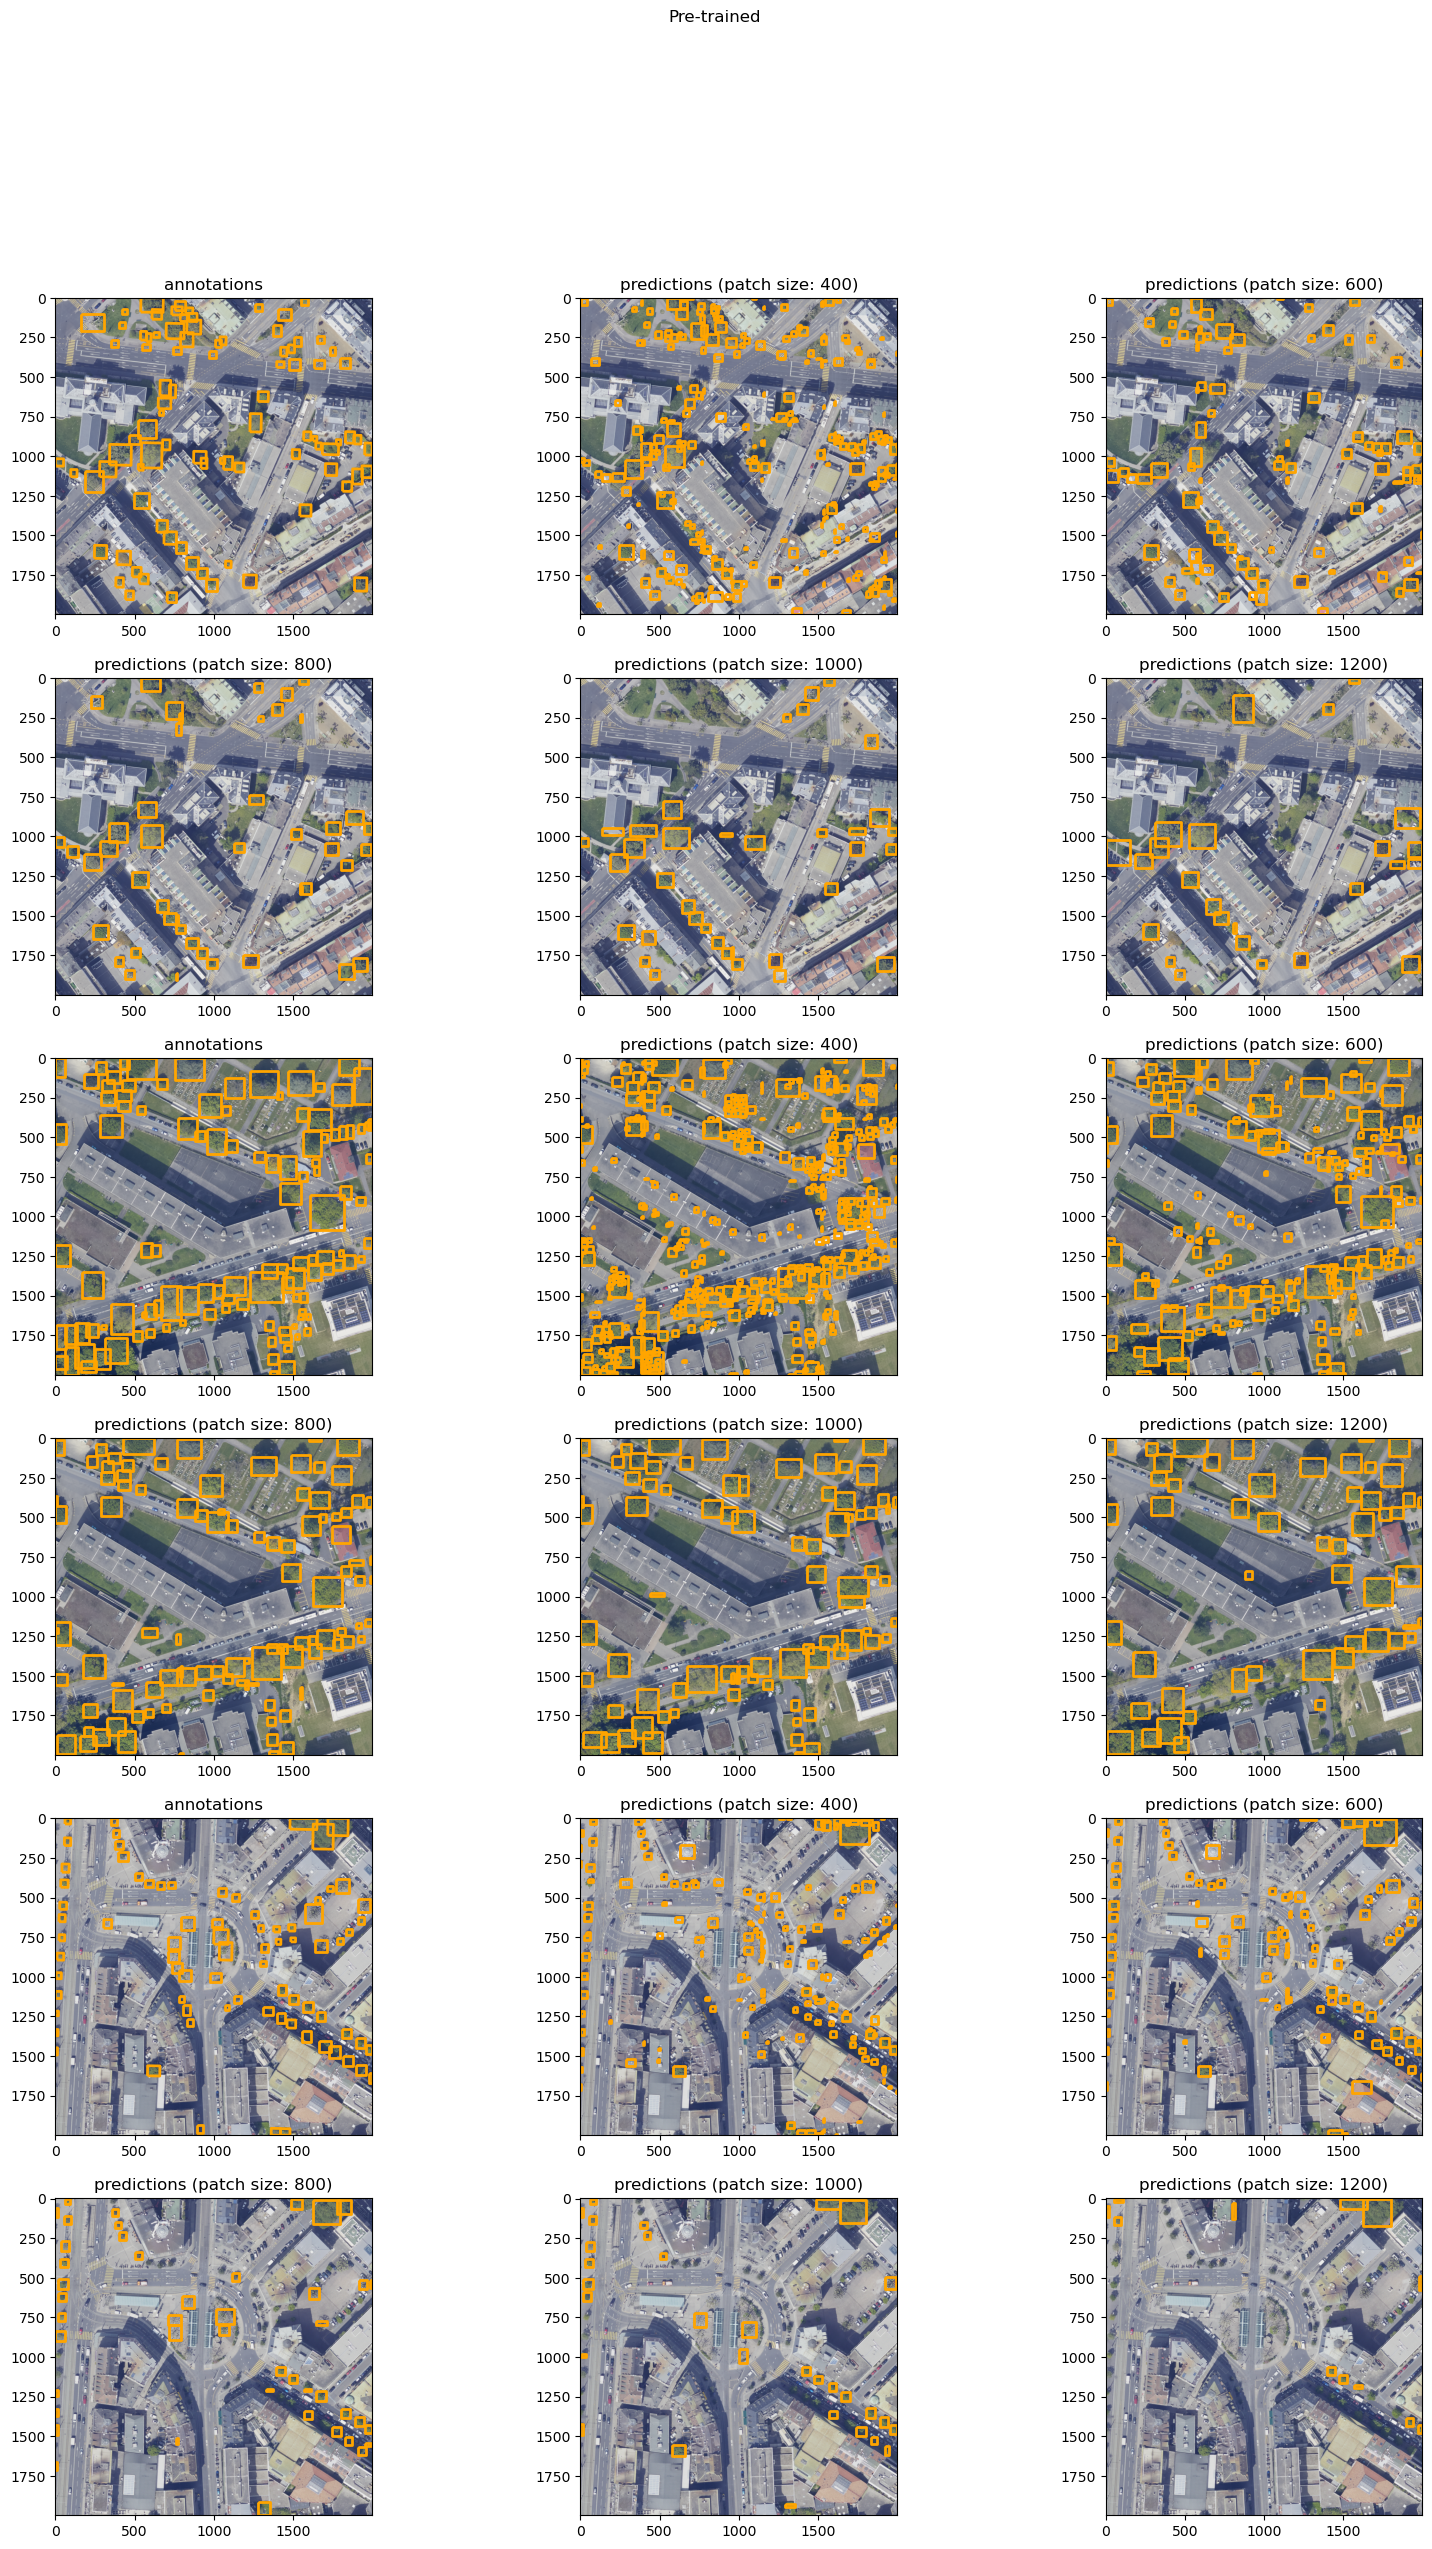

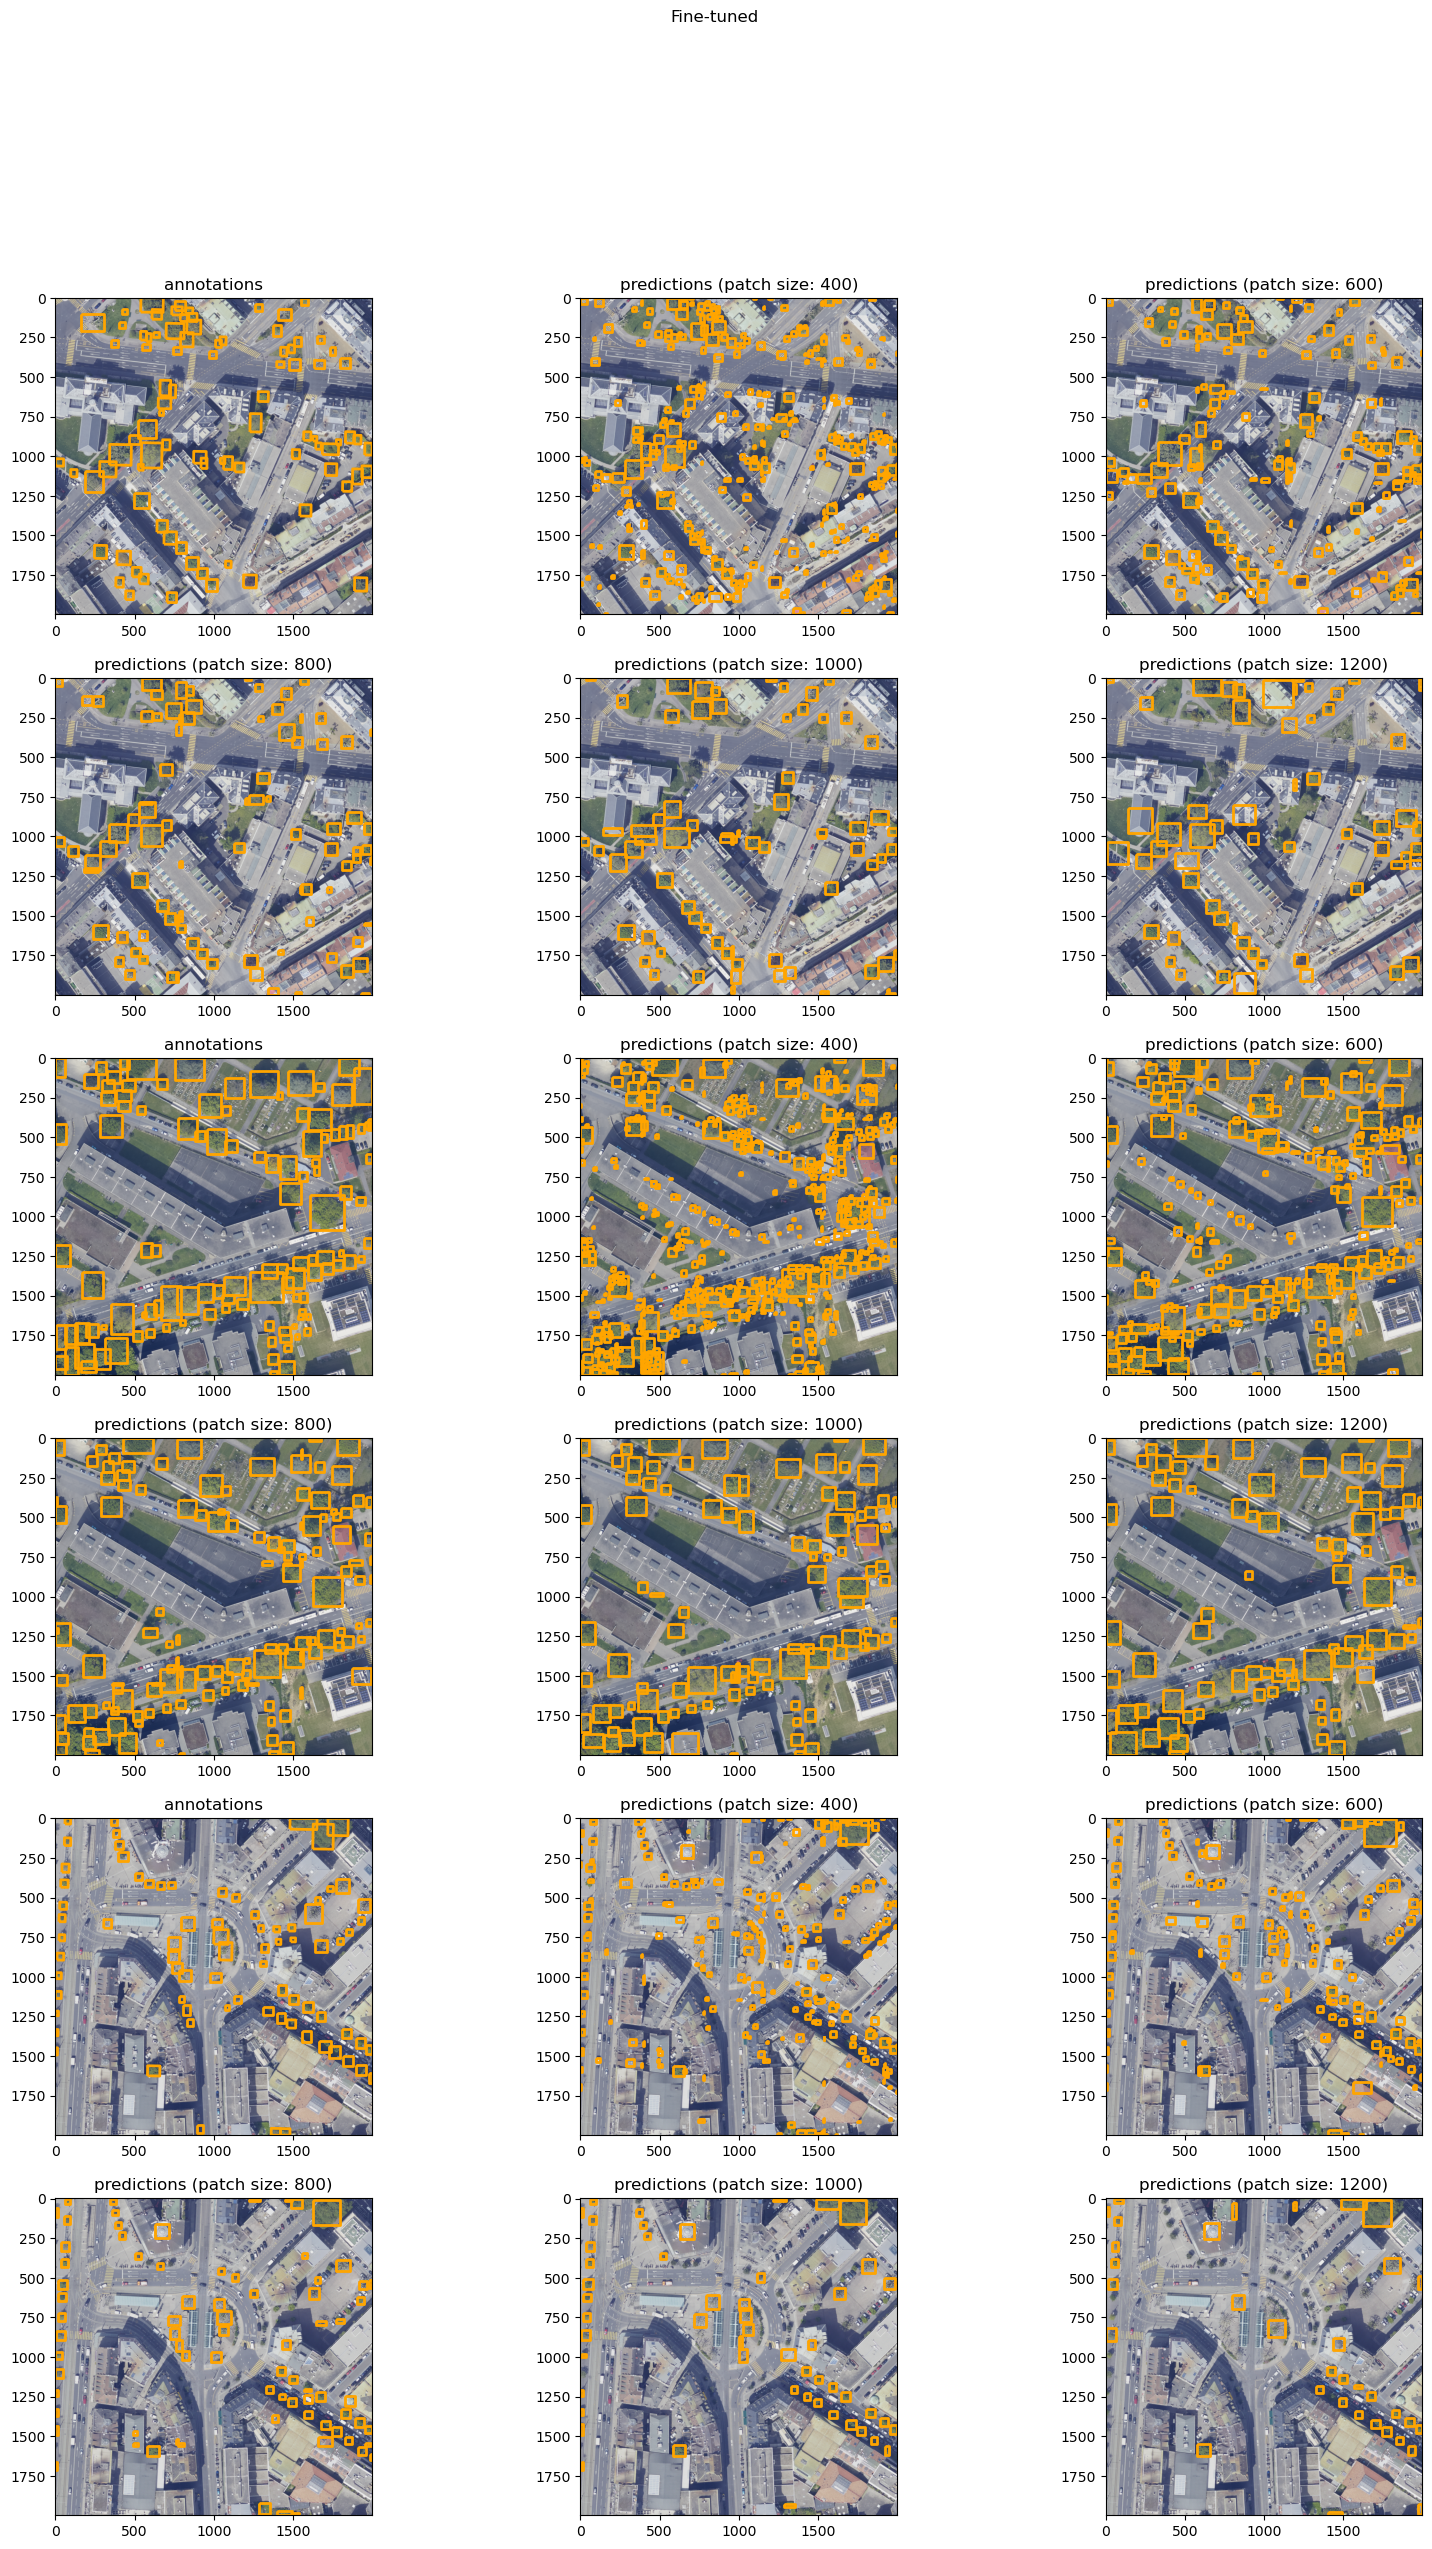

In [ ]:
for pred_gdf, title in zip(
    [pre_pred_gdf, ft_pred_gdf],
    ["Pre-trained", "Fine-tuned"],
):
    fig = plot.plot_annot_vs_pred(
        annot_gdf,
        pred_gdf,
        tile_dir,
        legend=False,
        plot_annot_kwargs=plot_annot_kwargs,
        plot_pred_kwargs=plot_pred_kwargs,
    )
    fig.suptitle(title)

At first glance, we can visually grasp that the pre-trained model works best wit a patch size around 600 px while the fine-tuned model seemingly performs best at larger patch sizes. In order to provide a quantitative evaluation, we will now compute the following metrics for both models:
- **intersection over union (IoU)**: the proportion of the area of overlap between the predicted and annotated bounding boxes to the area of their union
- **precision**: the proportion of predicted objects that have a ground truth positive match (for a given IoU threshold)
- **recall**: the proportion of ground truth objects that have a true positive match (for a given IoU threshold)
- **F1**: the harmonic mean of precision and recall, providing a measure of model performance that balances true positives and false negatives.

In [ ]:
pre_eval_df = deepforest_utils.multiscale_eval_df(
    pre_pred_gdf, annot_gdf, tile_dir, compute_f1=True
)
pre_eval_df

IoU  box_recall  box_precision  patch_size        F1
0  0.498258    0.630824       0.202532         400  0.306620
1  0.483193    0.659498       0.549849         600  0.599703
2  0.546824    0.519713       0.794444         800  0.628362
3  0.584285    0.448029       0.850340        1000  0.586854
4  0.576391    0.258065       0.886076        1200  0.399714

In [ ]:
ft_eval_df = deepforest_utils.multiscale_eval_df(
    ft_pred_gdf, annot_gdf, tile_dir, compute_f1=True
)
ft_eval_df

IoU  box_recall  box_precision  patch_size        F1
0  0.493168    0.616487       0.169307         400  0.265656
1  0.542077    0.741935       0.404297         600  0.523388
2  0.473849    0.666667       0.644599         800  0.655447
3  0.500676    0.577061       0.725225        1000  0.642715
4  0.520156    0.473118       0.776471        1200  0.587973

While the precision of the pre-trained model increases with the patch size, it does so at the expense of recall. This occurs because less tree crowns are being predicted, however a higher proportion of them are matched to a ground truth (hence the higher precision). Even though the fine-tuned model shows a similar behaviour, the recall values do not show such a significant decrease, therefore resulting in better F1 socres. The best F1 score is obtained for the fine-tuned model with a patch size of 1000 px.

We can also plot the F1 score as a function of the patch size for both models:

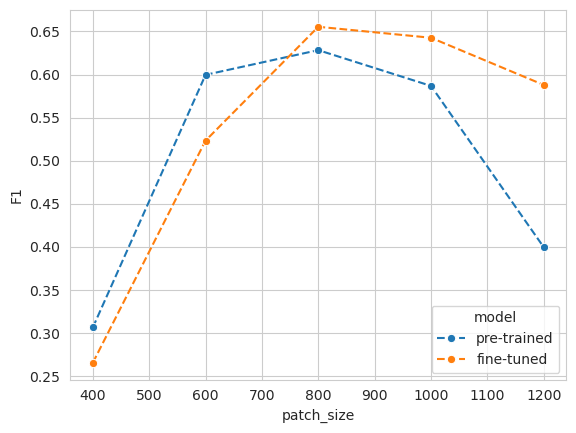

In [ ]:
with sns.axes_style("whitegrid"):
    sns.lineplot(
        pd.concat(
            [
                df.assign(**{"model": label})
                for df, label in zip(
                    [pre_eval_df, ft_eval_df], ["pre-trained", "fine-tuned"]
                )
            ]
        ),
        x="patch_size",
        y="F1",
        hue="model",
        linestyle="--",
        marker="o",
    )

## References

1. Weinstein, B. G., Marconi, S., Aubry‐Kientz, M., Vincent, G., Senyondo, H., & White, E. P. (2020). DeepForest: A Python package for RGB deep learning tree crown delineation. Methods in Ecology and Evolution, 11(12), 1743-1751.